In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import utils
from BayesModel import BFC, FC

import cProfile
import pstats

: 

In [ ]:
def double_train(*, model, optimer, size, device, epochs, enums=10):
    # model.to(device)
    pbar = tqdm(range(epochs))
    losses = {"total": [], "recon": [], "kl": []}
    for epoch in pbar:
        x = torch.random.normal(size)
        y = 2 * x
            # x, y = x.to(device), y.to(device)
        optimer.zero_grad()

            # sample batch enums times during training and average prediction before calculating loss
        outs = torch.zeros(enums, size)
        for j in range(enums):
            outs[j] = model(x, train=True)
        
        pred = outs.mean(0)  # take average of all predictions of each datapoint as final prediction of that datapoint 
        loss_kl = model.kl_reset() / (len(train) * enums)  # normalise by number of batches and enums
        loss_recon = -torch.distributions.Normal(pred, 0.1).log_prob(y).mean()

        loss =  loss_recon + loss_kl
        loss.backward()

        optimer.step()
        pbar.set_description(f"total loss: {loss:.4f}, recon. loss: {loss_recon:.4f}, kl_loss: {loss_kl:.4f}")
        losses["total"].append(loss.detach().numpy())
        losses["recon"].append(loss_recon.detach().numpy())
        losses["kl"].append(loss_kl.detach().numpy())

    return losses

def train_model_freq(*, model, optimer, train, device, epochs):
    pbar = tqdm(range(epochs))
    loss_fn = torch.nn.MSELoss()
    losses = []
    for epoch in pbar:
        for batch_idx, (x, y) in enumerate(train):
            x, y = x.to(device), y.to(device)
            optimer.zero_grad()

            # was simpler to copy code than generalize for non-kl_divergence
            pred = model(x.to(torch.float))
            loss = loss_fn(pred, y.to(torch.float))
            
            loss.backward()
            optimer.step()
        pbar.set_description(f"total loss: {loss:.4f}")
        losses.append(loss.detach().numpy())

    return losses

: 

In [ ]:
device = torch.device("cpu")
Bnet = BFC(features=1, classes=1, hiddens=[20,20], prior={"dist": "normal", "loc": 0, "scale": 1, "record": False})
Fnet = FC(features=1, classes=1, hiddens=[20,20], nonlin=nn.ReLU)
Boptimizer = torch.optim.AdamW(Bnet.parameters(), lr=0.01)
Foptimizer = torch.optim.AdamW(Fnet.parameters(), lr=0.01)

: 

In [72]:
train_model(model=net, optimer=optimizer, size=100, device=device, epochs=20, enums=10)

  0%|          | 0/200 [00:00<?, ?it/s]

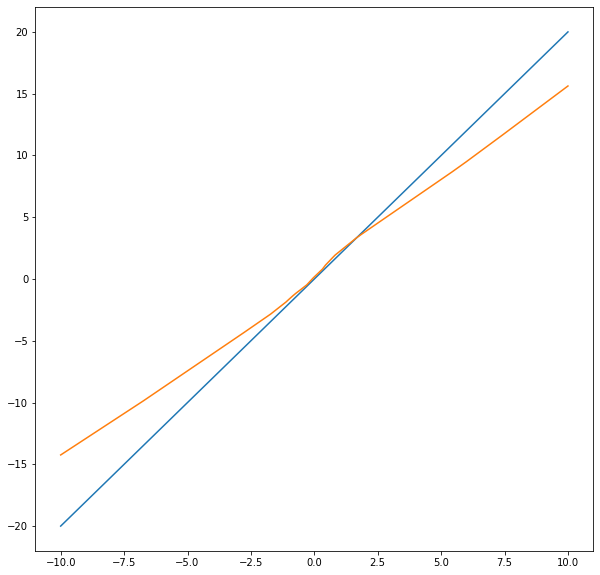

In [76]:
plt.rcParams["figure.figsize"] = (10,10)
x = np.linspace(-10, 10, 1001)[:, None]
d = net(torch.tensor(x)).detach().numpy()
plt.plot(x, 2*x)
plt.plot(x, d)